# 1. Download data from Kaggle



In [1]:
# Colab library to upload files to notebook
from google.colab import files

# Install Kaggle library
!pip install -q kaggle

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/*
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list
!kaggle competitions download -c facial-keypoints-detection

/root/.kaggle/kaggle.json
ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge           COVID-19 Open Research Dataset Challenge (CORD-19)  646MB  2020-03-20 23:31:34          20774  
unanimad/dataisbeautiful                                    Reddit - Data is Beautiful                           10MB  2020-03-13 16:34:07            369  
rubenssjr/brasilian-houses-to-rent                          brazilian_houses_to_rent                            117KB  2020-03-15 01:12:22            437  
sudalairajkumar/novel-corona-virus-2019-dataset             Novel Corona Virus 2019 Dataset                     381KB  2020-03-21 04:49:37          66623  
kimjihoo/coronavirusdataset           

# 2. Data Preprocessing & Exploratory Data Analysis

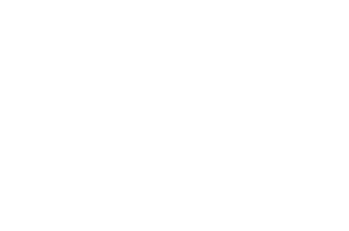

In [24]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import InputLayer, Dense, Activation, Dropout, Flatten, AveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

# print(f"keras version: {keras.__version__}")
# print(f"pandas version: {pd.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
IMAGE_WIDTH = 96

np.random.seed(0)

# load data
train_df = pd.read_csv("training.zip")
test_df = pd.read_csv("test.zip")
meta_data = pd.read_csv("IdLookupTable.csv")

In [4]:
print(train_df.info())

# find out number of number of rows with missing values
print(f"Total number of rows: {train_df.shape[0]}")
print(f"Total number of rows with NaN : {train_df.shape[0] - train_df.dropna().shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

There are 31 columns in this dataset. Each column except the last one represents a facial feature point as a float in given diemsion. Last column contains image dataset as a string. There are `4909` rows with missing values. 

It looks like there are two groups of features in the dataset. First group of features have the number of rows between 7016 ~ 7049. These are `left_eye_center_x `, `left_eye_center_y`, `right_eye_center_x`, `right_eye_center_y`, `mouth_center_bottom_lip_x`, and `mouth_center_bottom_lip_y`. Second group of features have the number of rows between 2225 ~ 2275. How do we handle this? Should we create two different models to handle each group? Or move the rows with missing values? Or fill in missing values other values. 

In [25]:
train_data = [x.split(' ') for x in train_df['Image'].tolist()]
train_data = np.asarray(train_data).astype(int).reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH, 1)
print('train data shape:', train_data.shape)

# make a copy of the dataframe before deleting column so the code can be run repeatedly during testing

# for now, use values from the previous rows
train_df2 = train_df.copy()
train_df2.fillna(method="ffill", inplace = True)

del train_df2['Image']
train_output = train_df2.to_numpy()
print('train output shape:', train_output.shape)

X_train = train_data[:6000]
Y_train = train_output[:6000]

X_dev = train_data[6000:]
Y_dev = train_output[6000:]

X_test = [x.split(' ') for x in test_df['Image'].tolist()]
X_test = np.asarray(X_test).astype(int).reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH, 1)
print('test data shape:', X_test.shape)

train data shape: (7049, 96, 96, 1)
train output shape: (7049, 30)
test data shape: (1783, 96, 96, 1)


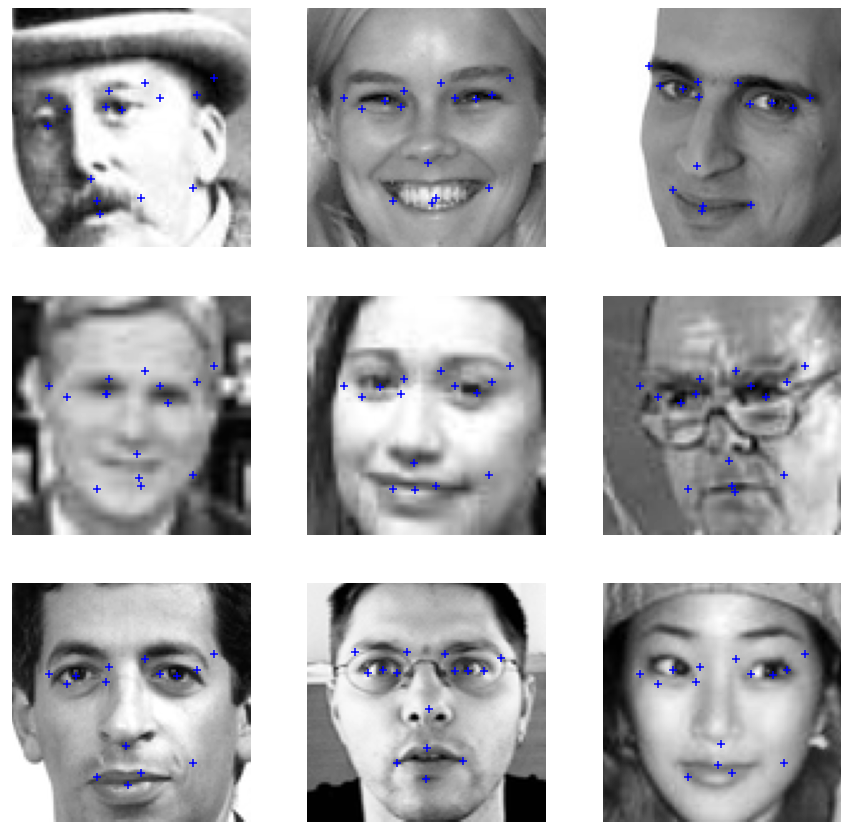

In [6]:
def plot_images(img_array, poi_array):
  fig, ax = plt.subplots(3,3, figsize=(15,15))
  plt.setp(ax, xticks=(), yticks=())  
  for row in range(9):   
      image = img_array[row,:].reshape(96, 96)
      poi = poi_array[row,:]
      i = int(np.floor(row/3))
      j = int(np.mod(row,3))

      ax[i,j].imshow(image, cmap="gray")
      
      for p in list(zip(poi[::2], poi[1::2])):
          ax[i,j].scatter(p[0], p[1], s=50, c='blue', marker='+')

  plt.show()

# generate 9 indicies to sample from
idx = np.random.randint(0, X_train.shape[0], size = 9).tolist()
plot_images(X_train[np.array(idx)], Y_train[np.array(idx)])

# 3. Baseline Model using Naive LeNet-5

In [7]:
# Compile a basic LeNet-5 model

def create_naive_LeNet5_model(input_shape):
  print(f"Initializing LeNet5 model with input-size: {input_shape}")
  model = Sequential()
  model.add(InputLayer(input_shape))
  model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(AveragePooling2D())
  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(AveragePooling2D())
  model.add(Flatten())
  model.add(Dense(units=120, activation='relu'))
  model.add(Dense(units=84, activation='relu'))
  model.add(Dense(units=30))
  return model

LeNet5_model = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

Initializing LeNet5 model with input-size: (96, 96, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
#train it!
result = LeNet5_model.fit(X_train,Y_train,epochs = 50,batch_size = 256,validation_split = 0.2)

Train on 4800 samples, validate on 1200 samples
Epoch 1/50
4800/4800 [==============================] - 8s 2ms/sample - loss: 3253.9697 - mean_absolute_error: 41.8254 - val_loss: 619.9403 - val_mean_absolute_error: 19.2749
Epoch 2/50
4800/4800 [==============================] - 0s 99us/sample - loss: 366.2647 - mean_absolute_error: 14.5410 - val_loss: 169.3283 - val_mean_absolute_error: 9.9173
Epoch 3/50
4800/4800 [==============================] - 0s 102us/sample - loss: 167.0842 - mean_absolute_error: 9.8720 - val_loss: 138.1253 - val_mean_absolute_error: 8.8685
Epoch 4/50
4800/4800 [==============================] - 0s 103us/sample - loss: 143.4675 - mean_absolute_error: 9.0756 - val_loss: 119.3923 - val_mean_absolute_error: 8.0992
Epoch 5/50
4800/4800 [==============================] - 0s 99us/sample - loss: 121.2442 - mean_absolute_error: 8.2734 - val_loss: 104.7262 - val_mean_absolute_error: 7.5894
Epoch 6/50
4800/4800 [==============================] - 0s 99us/sample - loss: 109

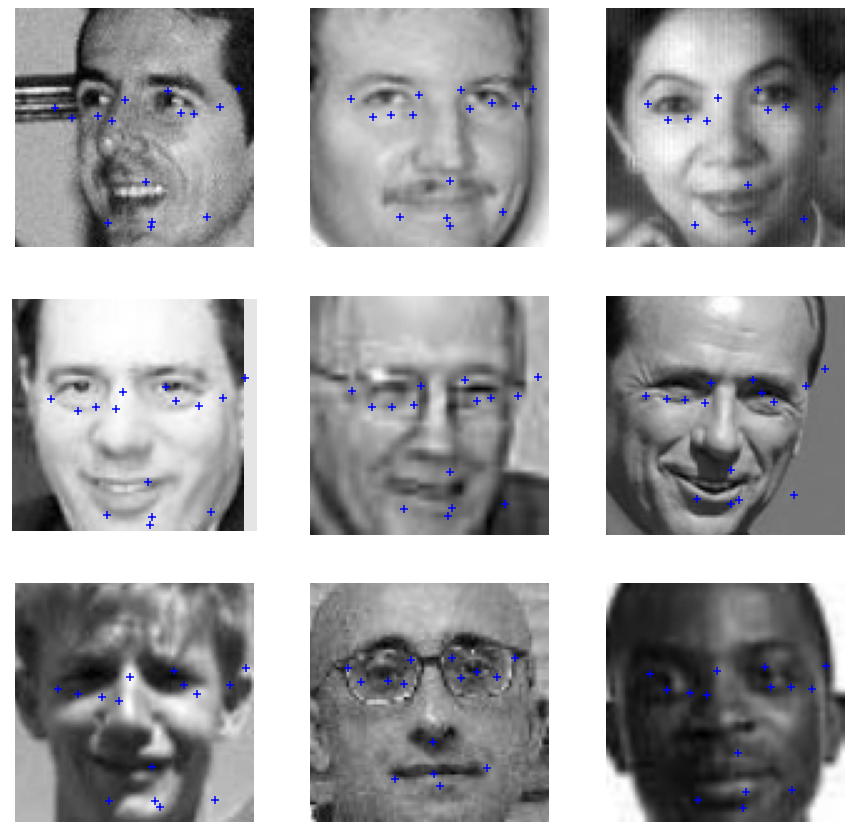

In [9]:
# predict and plot out some sample predictions

Y_dev_predicted = LeNet5_model.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)])

In [10]:
LeNet5_model.evaluate(X_dev, Y_dev)

1049/1049 [==============================] - 0s 117us/sample - loss: 72.5327 - mean_absolute_error: 6.2987


[72.53273905198613, 6.298724]

# Add in basic image augmentation

In [0]:
datagen = ImageDataGenerator(width_shift_range=0.25, height_shift_range = 0.25)
datagen.fit(X_train)

In [12]:
LeNet5_model2 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model2.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

result2 = LeNet5_model2.fit_generator(datagen.flow(X_train, Y_train, batch_size = 32), epochs = 50, steps_per_epoch = len(train_data) / 32)

Initializing LeNet5 model with input-size: (96, 96, 1)
Epoch 1/50
221/220 [==============================] - 6s 28ms/step - loss: 284.3041 - mean_absolute_error: 11.0658
Epoch 2/50
221/220 [==============================] - 6s 27ms/step - loss: 120.5185 - mean_absolute_error: 8.2610
Epoch 3/50
221/220 [==============================] - 6s 26ms/step - loss: 110.0904 - mean_absolute_error: 7.8617
Epoch 4/50
221/220 [==============================] - 6s 27ms/step - loss: 101.4455 - mean_absolute_error: 7.5625
Epoch 5/50
221/220 [==============================] - 6s 27ms/step - loss: 91.0793 - mean_absolute_error: 7.1745
Epoch 6/50
221/220 [==============================] - 6s 27ms/step - loss: 75.6894 - mean_absolute_error: 6.5340
Epoch 7/50
221/220 [==============================] - 6s 26ms/step - loss: 57.3463 - mean_absolute_error: 5.6667
Epoch 8/50
221/220 [==============================] - 6s 27ms/step - loss: 39.3051 - mean_absolute_error: 4.6377
Epoch 9/50
221/220 [================

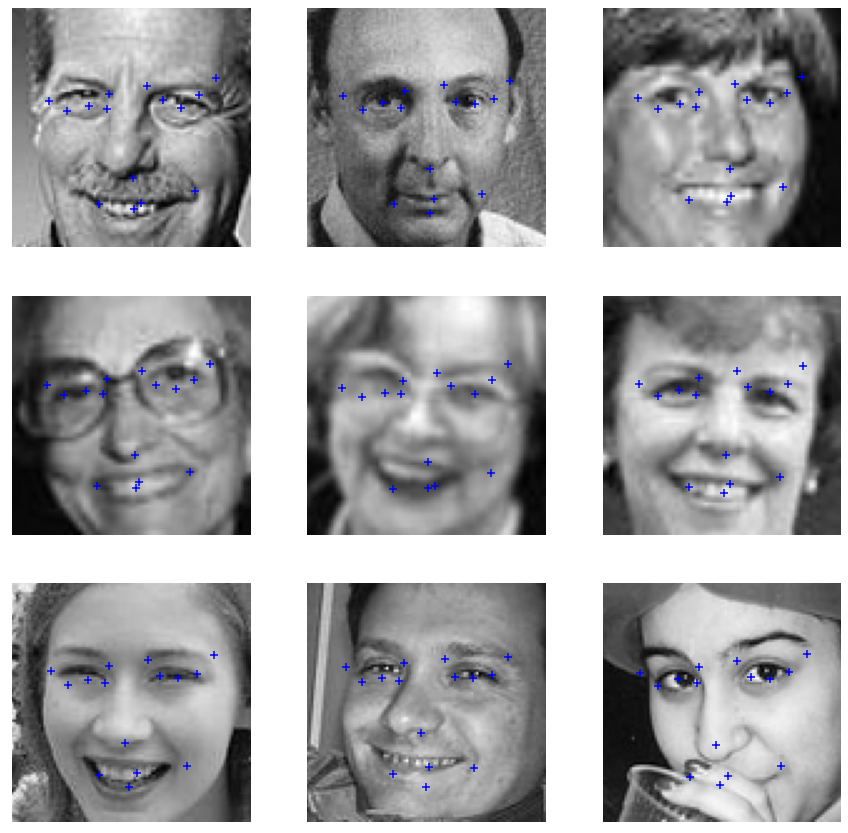

In [13]:
# predict and plot out some sample predictions

Y_dev_predicted = LeNet5_model2.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)])

In [14]:
LeNet5_model2.evaluate(X_dev, Y_dev)

1049/1049 [==============================] - 0s 140us/sample - loss: 5.1231 - mean_absolute_error: 1.2472


[5.123130881752254, 1.247228]

In [0]:
datagen2 = ImageDataGenerator(width_shift_range=0.25, height_shift_range = 0.25, rotation_range = 30)
datagen2.fit(X_train)

In [16]:
LeNet5_model3 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model3.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

result3 = LeNet5_model3.fit_generator(datagen2.flow(X_train, Y_train, batch_size = 32), epochs = 50, steps_per_epoch = len(train_data) / 32)

Initializing LeNet5 model with input-size: (96, 96, 1)
Epoch 1/50
221/220 [==============================] - 6s 29ms/step - loss: 203.3153 - mean_absolute_error: 9.8369
Epoch 2/50
221/220 [==============================] - 6s 28ms/step - loss: 119.0500 - mean_absolute_error: 8.2021
Epoch 3/50
221/220 [==============================] - 6s 28ms/step - loss: 111.3576 - mean_absolute_error: 7.9273
Epoch 4/50
221/220 [==============================] - 6s 28ms/step - loss: 98.8490 - mean_absolute_error: 7.4355
Epoch 5/50
221/220 [==============================] - 6s 27ms/step - loss: 76.7994 - mean_absolute_error: 6.5761
Epoch 6/50
221/220 [==============================] - 6s 28ms/step - loss: 45.6200 - mean_absolute_error: 5.0190
Epoch 7/50
221/220 [==============================] - 6s 27ms/step - loss: 26.9625 - mean_absolute_error: 3.8125
Epoch 8/50
221/220 [==============================] - 6s 27ms/step - loss: 18.2841 - mean_absolute_error: 3.0872
Epoch 9/50
221/220 [==================

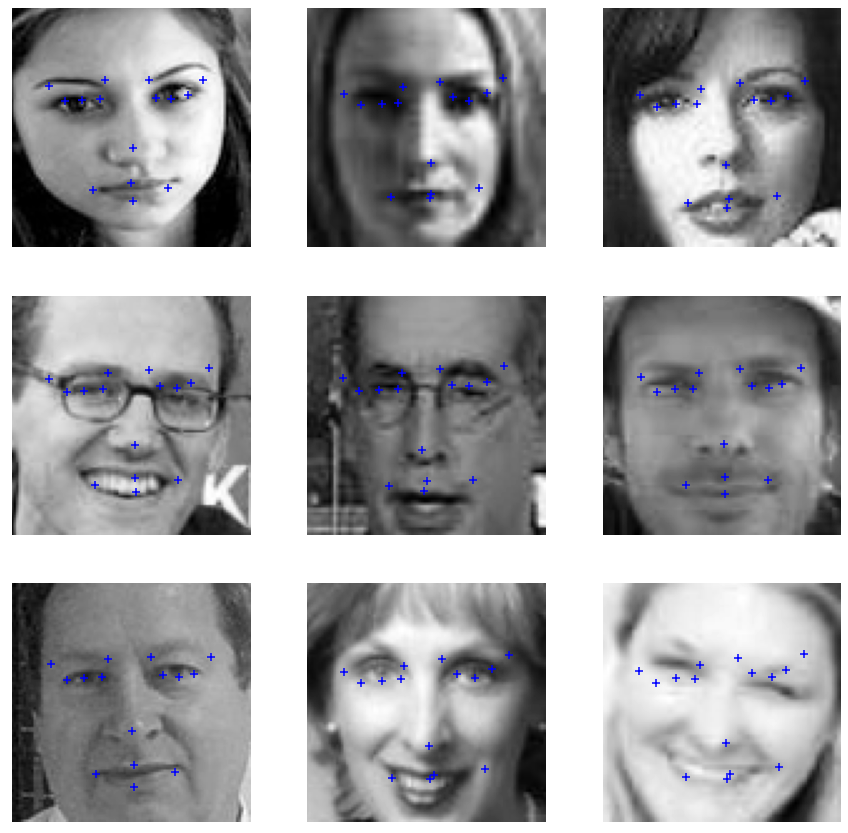

In [17]:
# predict and plot out some sample predictions

Y_dev_predicted = LeNet5_model3.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)])

In [18]:
LeNet5_model3.evaluate(X_dev, Y_dev)

1049/1049 [==============================] - 0s 148us/sample - loss: 7.4984 - mean_absolute_error: 1.7242


[7.498442007088457, 1.7242063]

In [0]:
datagen3 = ImageDataGenerator(width_shift_range=0.25, height_shift_range = 0.25, horizontal_flip = True)
datagen3.fit(X_train)

In [20]:
LeNet5_model4 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model4.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

result4 = LeNet5_model4.fit_generator(datagen3.flow(X_train, Y_train, batch_size = 32), epochs = 50, steps_per_epoch = len(train_data) / 32)

Initializing LeNet5 model with input-size: (96, 96, 1)
Epoch 1/50
221/220 [==============================] - 6s 28ms/step - loss: 254.4471 - mean_absolute_error: 10.5796
Epoch 2/50
221/220 [==============================] - 6s 27ms/step - loss: 23.2652 - mean_absolute_error: 3.2771
Epoch 3/50
221/220 [==============================] - 6s 27ms/step - loss: 11.6496 - mean_absolute_error: 2.2572
Epoch 4/50
221/220 [==============================] - 6s 27ms/step - loss: 11.1532 - mean_absolute_error: 2.1761
Epoch 5/50
221/220 [==============================] - 6s 27ms/step - loss: 10.5486 - mean_absolute_error: 2.1206
Epoch 6/50
221/220 [==============================] - 6s 27ms/step - loss: 10.3496 - mean_absolute_error: 2.0807
Epoch 7/50
221/220 [==============================] - 6s 27ms/step - loss: 10.2470 - mean_absolute_error: 2.0763
Epoch 8/50
221/220 [==============================] - 6s 27ms/step - loss: 10.3342 - mean_absolute_error: 2.0731
Epoch 9/50
221/220 [===================

In [21]:
LeNet5_model4.evaluate(X_dev, Y_dev)

1049/1049 [==============================] - 0s 156us/sample - loss: 6.9825 - mean_absolute_error: 1.6788


[6.982469940549198, 1.6787952]

In [31]:
# make a copy of the data frame so this block can run repeatedly during testing
train_df3 = train_df.copy()

del train_df3['Image']

# fillna with median
for c in train_df3.columns:
  train_df3[c] = train_df3[c].fillna(train_df3[c].median(skipna = True))
  
train_output2 = train_df3.to_numpy()
print('train output shape:', train_output2.shape)

Y_train2 = train_output2[:6000]
Y_dev2 = train_output2[6000:]

train output shape: (7049, 30)


In [32]:
LeNet5_model5 = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model5.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

result6 = LeNet5_model5.fit_generator(datagen.flow(X_train, Y_train2, batch_size = 32), epochs = 50, steps_per_epoch = len(train_data) / 32)

Initializing LeNet5 model with input-size: (96, 96, 1)
Epoch 1/50
221/220 [==============================] - 6s 29ms/step - loss: 175.5642 - mean_absolute_error: 9.4420
Epoch 2/50
221/220 [==============================] - 6s 28ms/step - loss: 91.2368 - mean_absolute_error: 7.1062
Epoch 3/50
221/220 [==============================] - 6s 27ms/step - loss: 30.9812 - mean_absolute_error: 3.8898
Epoch 4/50
221/220 [==============================] - 6s 27ms/step - loss: 9.8955 - mean_absolute_error: 2.0221
Epoch 5/50
221/220 [==============================] - 6s 28ms/step - loss: 9.2543 - mean_absolute_error: 1.8273
Epoch 6/50
221/220 [==============================] - 6s 28ms/step - loss: 8.7893 - mean_absolute_error: 1.7677
Epoch 7/50
221/220 [==============================] - 6s 28ms/step - loss: 8.5888 - mean_absolute_error: 1.7236
Epoch 8/50
221/220 [==============================] - 6s 28ms/step - loss: 8.3522 - mean_absolute_error: 1.6769
Epoch 9/50
221/220 [=========================

In [33]:
LeNet5_model5.evaluate(X_dev, Y_dev2)

1049/1049 [==============================] - 0s 202us/sample - loss: 5.0668 - mean_absolute_error: 1.0956


[5.066801703919446, 1.0956438]

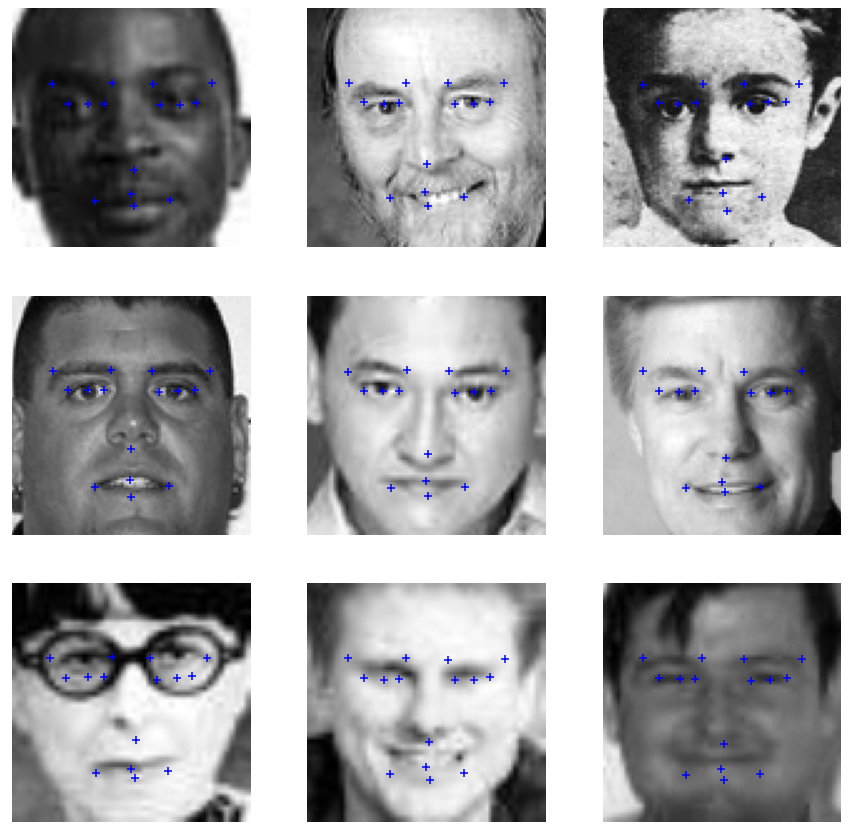

In [35]:
Y_dev_predicted = LeNet5_model5.predict(X_dev)

idx = np.random.randint(0, X_dev.shape[0], size = 9).tolist()
plot_images(X_dev[np.array(idx)], Y_dev_predicted[np.array(idx)])

In [22]:
# Compile a basic VGG16 model

def create_VGG16_model(input_shape):
  print(f"Initializing LeNet16 model with input-size: {input_shape}")
  model = Sequential()
  model.add(InputLayer(input_shape))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=30, activation="softmax"))
  return model

vgg_model = create_VGG16_model(X_train.shape[1:])
vgg_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

Initializing LeNet16 model with input-size: (96, 96, 1)


In [23]:
result5 = vgg_model.fit_generator(datagen2.flow(X_train, Y_train, batch_size = 32), epochs = 20, steps_per_epoch = len(train_data) / 32)

Epoch 1/20
221/220 [==============================] - 26s 119ms/step - loss: 2666.0045 - mean_absolute_error: 48.1142
Epoch 2/20
221/220 [==============================] - 22s 98ms/step - loss: 2667.9421 - mean_absolute_error: 48.1327
Epoch 3/20
221/220 [==============================] - 22s 99ms/step - loss: 2665.7352 - mean_absolute_error: 48.1112
Epoch 4/20
221/220 [==============================] - 22s 99ms/step - loss: 2665.1711 - mean_absolute_error: 48.1037
Epoch 5/20
221/220 [==============================] - 22s 100ms/step - loss: 2668.2120 - mean_absolute_error: 48.1296
Epoch 6/20
221/220 [==============================] - 22s 100ms/step - loss: 2666.3722 - mean_absolute_error: 48.1181
Epoch 7/20
221/220 [==============================] - 22s 101ms/step - loss: 2667.7150 - mean_absolute_error: 48.1283
Epoch 8/20
221/220 [==============================] - 22s 101ms/step - loss: 2665.1615 - mean_absolute_error: 48.1064
Epoch 9/20
221/220 [==============================] - 22s 1